# ieee-cis Fraud Detection
## EDA 부터 XGB hyperopt로 모델링까지
**[참고한 커널](https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt)**

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

#standard plotly imports
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode

#import cufflinks
import plotly.figure_factory as ff

#using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)

#preprocessing, modeling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
import xgboost as xgb

#hyperparameter optimization modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
print(os.listdir("../input"))

['sample_submission.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']


In [2]:
%%time
df_id = pd.read_csv('../input/train_identity.csv')
df_trans = pd.read_csv('../input/train_transaction.csv')

Wall time: 38.4 s


In [3]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns = ['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Thrid Value'] = df.loc[2].values
    
    for name in summary['Name'].value_counts().index: # 즉 각 value에 대하여
        summary.loc[summary['Name'] == name, 'Entropy'] = round(
        stats.entropy(df[name].value_counts(normalize = True), base=2), 2)
        # stats.entropy는 뭔지 찾아보기
    return summary

# DF size를 줄이는 함수
# def reduce_mem_usage(df, verbose=True):
#     numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#     start_mem = df.memory_usage().sum() / 1024**2
#     for col in df.columns:
#         col_type = df[col].dtypes
#         if col_type in numerics: # numerics 중 해당하는 값 있다면?
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int16)
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16.max):
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32.max):
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)
    
#     end_mem = df.memory_usage().sum() / 1024**2
#     if verbose:
#         print('Mem. usage decreased to {:5.2f}Mb to {:.1f} reduction'.format(
#         end_mem, 100 * (start_mem - end_mem) / start_mem))
    
#     return df

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
        end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

def CalcOutliers(df_num):
    # array의 평균, 표준편차 계산
    data_mean, data_std = np.mean(df_num), np.std(df_num)
    
    # 상한, 하한 범위 설정
    cut = data_std * 3
    
    # 상한, 하한값 설정
    lower, upper = data_mean - cut, data_mean + cut
    
    # outliers values 생성
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]
    
    # array without outlier values. lower, upper 와 같은 경우는 뺌??
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lower outliers: %d' % len(outliers_lower))
    print('Identified upper outliers: %d' % len(outliers_higher))
    print('Total outlier observations: %d' % len(outliers_total))
    print('Non-outlier observations: %d' % len(outliers_removed))
    print('Total percentual of Outliers:', round((
        len(outliers_total) / len(outliers_removed)) * 100, 4))
    
    return

In [4]:
%%time
# Reducing memory
df_trans = reduce_mem_usage(df_trans)
df_id = reduce_mem_usage(df_id)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)


In [5]:
resumetable(df_trans)[:25] #25행(25번째 칼럼)까지만 출력

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Thrid Value,Entropy
0,TransactionID,int32,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int8,0,2,0,0,0,0.22
2,TransactionDT,int32,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float16,0,8195,68.5,29,59,8.10
4,ProductCD,object,0,5,W,W,W,1.28
5,card1,int16,0,13553,13926,2755,4663,9.97
6,card2,float16,8933,500,NaN,404,490,6.32
7,card3,float16,1565,114,150,150,150,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float16,4259,119,142,102,166,2.66


In [5]:
# imbalanced 되어 있는지 확인 -> Fraud는 3.5% 뿐!
df_trans['isFraud'].value_counts() / df_trans.shape[0] * 100

0    96.500999
1     3.499001
Name: isFraud, dtype: float64

In [24]:
print(df_id.shape)
df_id.head()

(144233, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


## Target Distribution

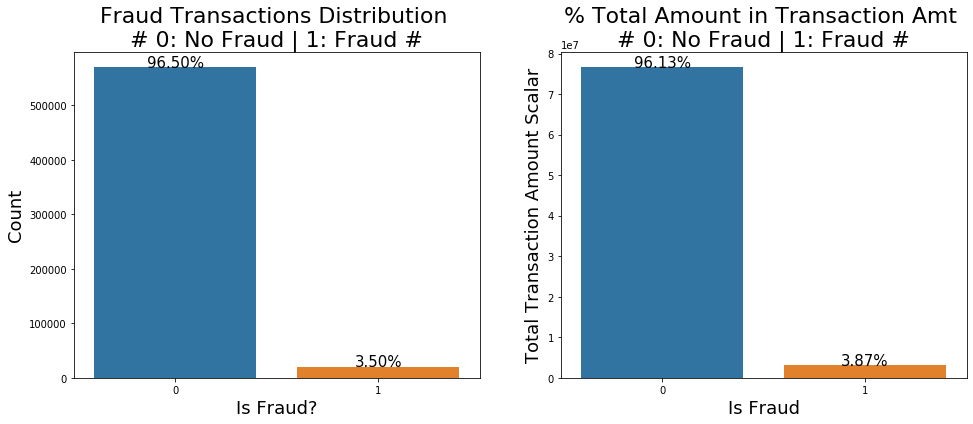

In [48]:
# 굳이 float16 -> float64로 하는 이유가?
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total = len(df_trans)
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum() #총 거래량 합
plt.figure(figsize=(16, 6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data=df_trans)
g.set_title('Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #',
           fontsize=22)
g.set_xlabel('Is Fraud?', fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    # 아래코드는 위치(1,2번째 인자)와 값을 그래프에 넣어주는 함수인 듯
    g.text(p.get_x() + p.get_width()/2., height + 3, 
          "{:1.2f}%".format(height / total * 100), ha="center", fontsize=15)

#아래 코드에서 바깥 괄호는 왜 씌우는 건지?
perc_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum()
perc_amt = perc_amt.reset_index()

plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt', dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #",
            fontsize=22)
g1.set_xlabel("Is Fraud", fontsize=18)
g1.set_ylabel("Total Transaction Amount Scalar", fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width() / 2., height + 3,
           '{:1.2f}%'.format(height / total_amt * 100), ha = "center",
           fontsize=15)
    
plt.show()

- Fraud 비율(3.5%)과 Transaction amount 중에서 Fraud가 차지하는 비율(3.87%)이 유사한 것이 흥미로움

In [49]:
# TransAmt의 quantile 살펴보기
print("Transaction Amounts Quantiles:")
print(df_trans['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75,
                                          .9, .975, .99, 1]))

Transaction Amounts Quantiles:
0.010        9.242188
0.025       14.500000
0.100       25.953125
0.250       43.312500
0.500       68.750000
0.750      125.000000
0.900      275.250000
0.975      648.262500
0.990     1104.000000
1.000    31936.000000
Name: TransactionAmt, dtype: float64


In [50]:
df_trans['TransactionAmt'].describe()

count    590540.000000
mean        135.027347
std         239.157438
min           0.250977
25%          43.312500
50%          68.750000
75%         125.000000
max       31936.000000
Name: TransactionAmt, dtype: float64

### Plotting Transactinon Amount Values Distribution

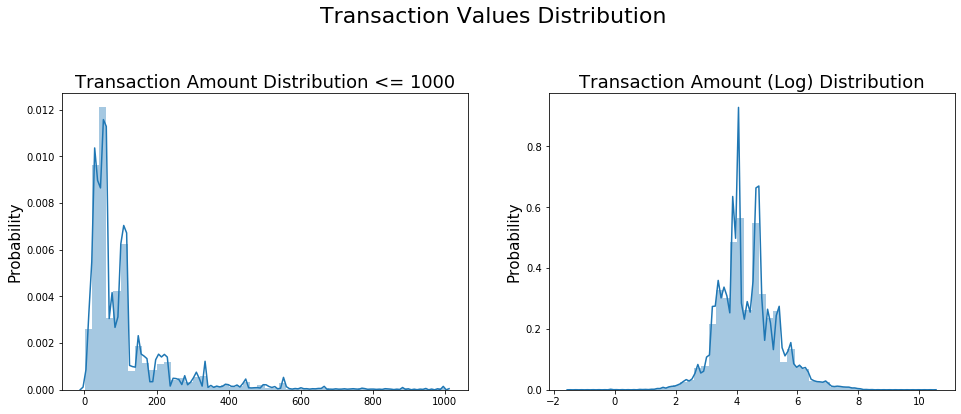

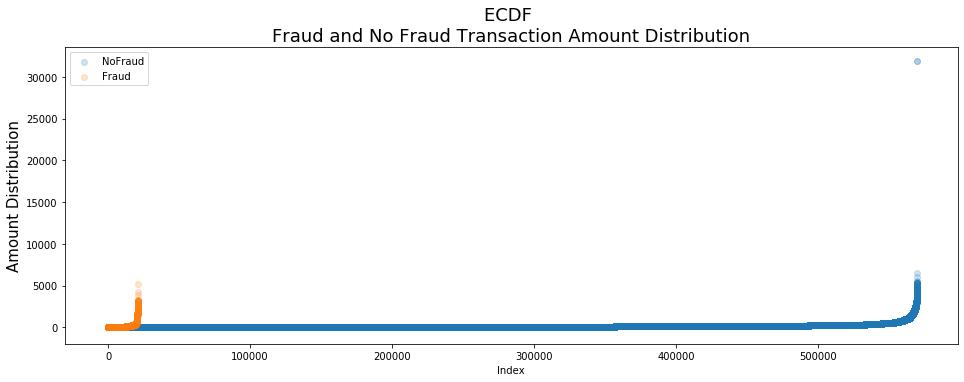

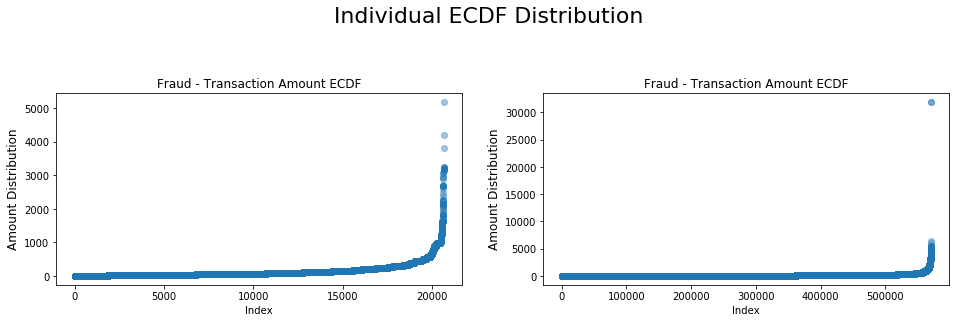

In [60]:
# 1행
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22) #super title?
plt.subplot(221)
g = sns.distplot(df_trans[df_trans['TransactionAmt'] <= 1000]['TransactionAmt'])
g.set_title("Transaction Amount Distribution <= 1000", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(df_trans['TransactionAmt']))
g1.set_title("Transaction Amount (Log) Distribution", fontsize=18)
g1.set_xlabel("")
g1.set_ylabel("Probability", fontsize=15)

# 2행
plt.figure(figsize=(16, 12))
plt.subplot(212)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                np.sort(
                df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values),
        label = 'NoFraud', alpha=.2)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]),
                np.sort(
                df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values),
        label= 'Fraud', alpha=.2)
g4 = plt.title("ECDF \nFraud and No Fraud Transaction Amount Distribution",
              fontsize=18)
g4 = plt.xlabel("Index")
g4 = plt.ylabel("Amount Distribution", fontsize=15)
g4 = plt.legend()

# 3행 -> 2행의 결과를 Fraud, No Fraud 따로 시각화하기
plt.figure(figsize=(16, 12))
plt.subplot(321)
g = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]),
               np.sort(
                df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values),
        label = 'Fraud', alpha=.4)
plt.title("Fraud - Transaction Amount ECDF")
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
g1 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
               np.sort(
                df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values),
        label = 'No Fraud', alpha=.4)
g1 = plt.title("Fraud - Transaction Amount ECDF")
g1 = plt.xlabel("Index")
g1 = plt.ylabel("Amount Distribution", fontsize=12)

plt.suptitle("Individual ECDF Distribution", fontsize=22)

plt.show()

### Fraud, No Fraud Transaction의 quantile 확인

In [62]:
print(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].mean())
print(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].mean())

134.51185725859278
149.24435261605134


In [66]:
pd.concat([df_trans[df_trans['isFraud'] == 1]['TransactionAmt']\
          .quantile([.01, .1, .25, .5, .75, .9, .99]).reset_index(),
           df_trans[df_trans['isFraud'] == 0]['TransactionAmt']\
          .quantile([.01, .1, .25, .5, .75, .9, .99]).reset_index()],
         axis=1, keys=['Fraud', 'No Fraud'])
# 유사한 quantile을 보임

Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01       6.739453     0.01       9.511875
1  0.10      18.937500     0.10      26.312500
2  0.25      35.031250     0.25      43.968750
3  0.50      75.000000     0.50      68.500000
4  0.75     161.000000     0.75     120.000000
5  0.90     335.000000     0.90     267.100000
6  0.99     994.000000     0.99    1104.000000

### Transaction Amount Outliers
- 평균 +- 3td

In [71]:
CalcOutliers(df_trans['TransactionAmt'])

Identified lower outliers: 0
Identified upper outliers: 10097
Total outlier observations: 10097
Non-outlier observations: 580443
Total percentual of Outliers: 1.7395


- 전체 행 중 1.74% 정도인 1만개 정도의 행에 outlier가 있음

## Product Feature 알아보기
- productCD Distribution
- product에 따른 Fraud의 분포
- product별로 Transactino Amount가 다른지 확인

isFraud ProductCD    NoFraud      Fraud
0               C  88.312731  11.687269
1               H  95.233769   4.766231
2               R  96.217406   3.782594
3               S  94.100447   5.899553
4               W  97.960061   2.039939


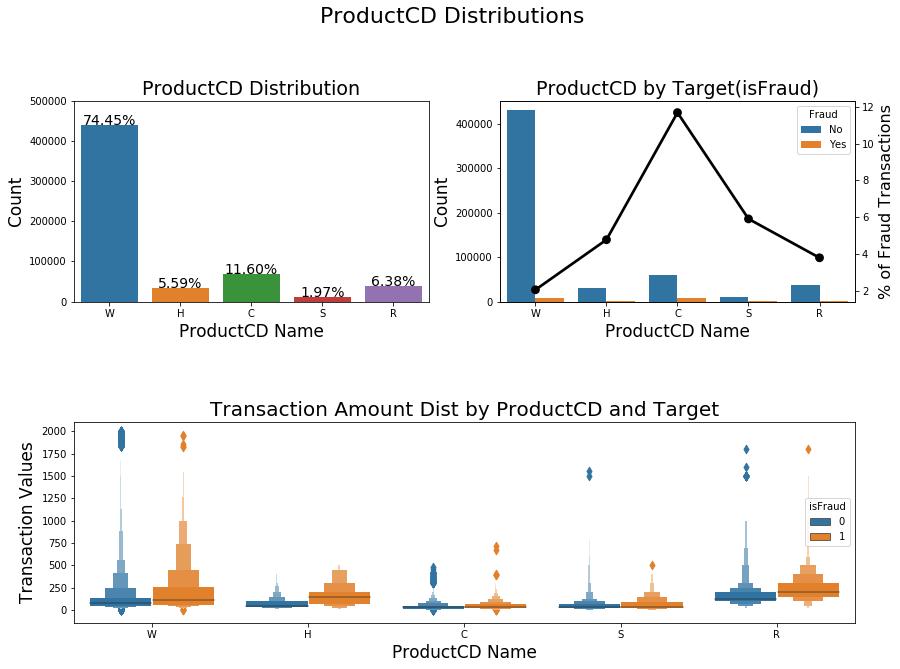

In [94]:
tmp = pd.crosstab(df_trans['ProductCD'], df_trans['isFraud'],
                 normalize='index') * 100
tmp = tmp.reset_index()
# 칼럼명이 0,1인 칼럼의 이름 바꾸기. reset_index 하고 난 이후이므로
# Fraud, No Fraud가 구분됨
tmp.rename(columns = {0:'NoFraud', 1:'Fraud'}, inplace=True)
print(tmp)

plt.figure(figsize=(14, 10))
plt.suptitle("ProductCD Distributions", fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=df_trans)
g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0, 500000) # 바 위에 숫자 표기 위해 조금 늘림
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width() / 2., height + 3,
          '{:1.2f}%'.format(height / total * 100), ha="center", fontsize=14)

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx() #반대쪽(y축) 인덱스대로 그리기
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black',
                  order=['W', 'H', 'C', 'S', 'R'], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("ProductCD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
#boxenplot -> boxplot보다 좀더 진화된 plot인 듯
g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud',
                  data=df_trans[df_trans['TransactionAmt'] <= 2000])
g3.set_title("Transaction Amount Dist by ProductCD and Target",
            fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

#그림 간 간격 조정
plt.subplots_adjust(hspace=0.6, top=0.85)

plt.show()

- 1) W,C,R 그룹 빈도가 많음
- 2) C 그룹에서 Fraud 비율이 많음
- 3) W,H,R 그룹에서 Fraud의 거래량(**주황색**)이 Non-Fraud 거래량보다 약간 더 많음

## Card Feature 알아보기
- competition 설명에 따라 card feature는 범주형(card1 ~ card6)
- 각 feature에 따라 Fraud, Non-Fraud 비율 살펴보기
- 6개 변수 중 4개는 numeric, 2개는 범주형(카드 회사와 카드 종류(직불, 신용))

In [95]:
# card feature 살펴보기
resumetable(df_trans[['card1', 'card2', 'card3', 'card4', 'card5', 'card6']])

Dataset Shape: (590540, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Thrid Value,Entropy
0,card1,int16,0,13553,13926,2755,4663,9.97
1,card2,float16,8933,500,NaN,404,490,6.32
2,card3,float16,1565,114,150,150,150,0.68
3,card4,object,1577,4,discover,mastercard,visa,1.09
4,card5,float16,4259,119,142,102,166,2.66
5,card6,object,1571,4,credit,credit,debit,0.82


- card2 ~ card6은 결측치 있음. 뒤에서 다시 다룸

In [97]:
print("Card Feature Quantiles:")
print(df_trans[['card1', 'card2', 'card3', 'card5']].quantile([
    .01, .025, .1, .25, .5, .75, .975, .99, 1
]))

Card Feature Quantiles:
         card1  card2  card3  card5
0.010   1338.0  100.0  144.0  102.0
0.025   1675.0  111.0  150.0  102.0
0.100   2803.0  111.0  150.0  126.0
0.250   6019.0  214.0  150.0  166.0
0.500   9678.0  361.0  150.0  226.0
0.750  14184.0  512.0  150.0  226.0
0.975  18018.0  583.0  185.0  226.0
0.990  18238.0  583.0  185.0  226.0
1.000  18396.0  600.0  231.0  237.0


- 상대적으로 card1, card2가 넓게 분포되어 있음 -> log 취하기

- card3, card5의 value_counts를 보면 최대 10만 대인 count도 있음
- **따라서 기타 범주는 Others로 묶기**

In [102]:
print(df_trans.card3.value_counts().head())
print(df_trans.card5.value_counts().head())
df_trans.loc[
df_trans.card3.value_counts()[df_trans.card3.value_counts() < 200].index,
'card3'] = "Others"
df_trans.loc[
df_trans.card5.value_counts()[df_trans.card5.value_counts() < 300].index,
'card5'] = "Others"

150.0    521287
185.0     56346
106.0      1571
146.0      1252
144.0      1252
Name: card3, dtype: int64
226.0    296546
224.0     81513
166.0     57140
102.0     29105
117.0     25941
Name: card5, dtype: int64


### card1, 2, 3 분포 시각화